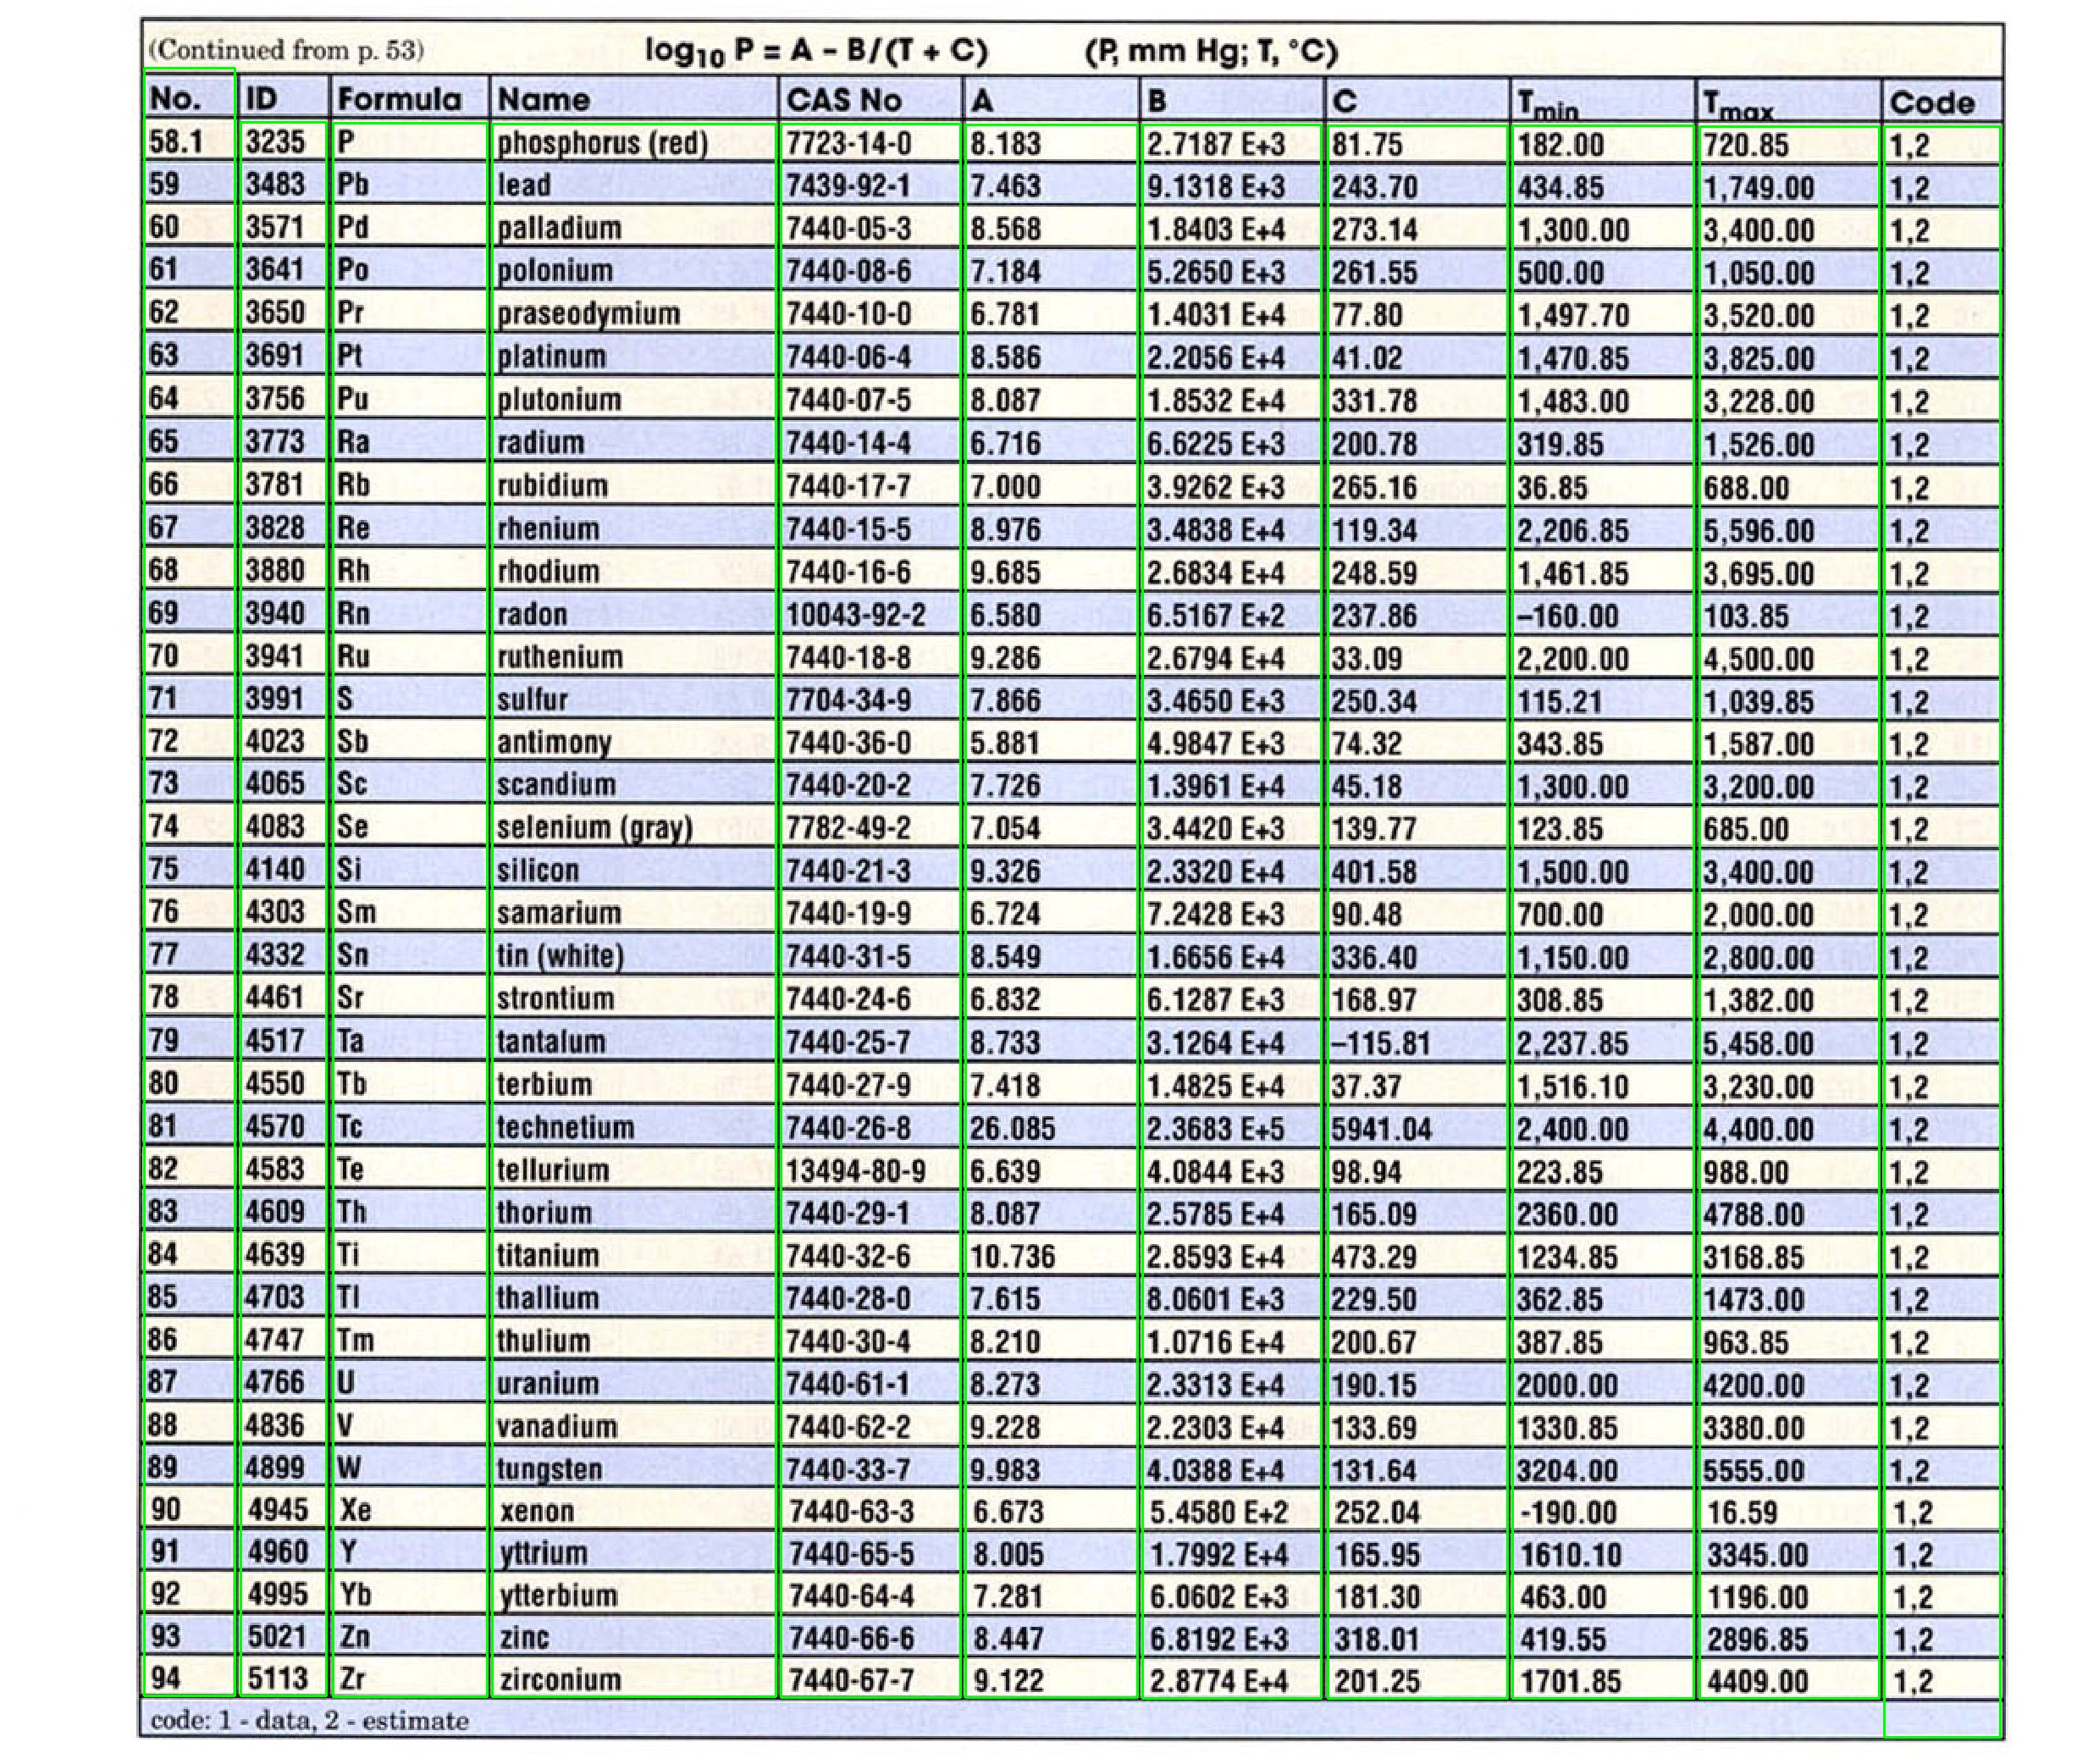

In [1]:
import IPython.display as display
import numpy as np
import cv2

def show(img, save="result.jpg"):
    cv2.imwrite(save, img)
    display.display(display.Image(save))
    
img = cv2.imread("table2.jpg")
img_copy = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

thresh2, img_bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
def noise_removal(image):
    ker = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, ker, iterations=1)
    image = cv2.erode(image, ker, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, ker)
    image = cv2.medianBlur(image, 3)
    return image
def thin_font(image):
    image = cv2.bitwise_not(image)
    ker = np.ones((2,2), np.uint8)
    image = cv2.erode(image, ker, iterations=1)
    image = cv2.bitwise_not(image)
    return image
no_noise = noise_removal(img_bw)
eroded_img = thin_font(no_noise)

vert_ker = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//150))
vert_erode = cv2.erode(thresh1, vert_ker, iterations=5)
vert_dilate = cv2.dilate(vert_erode, vert_ker, iterations=5)

cnts = cv2.findContours(vert_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

cor1, cor2 = [], []
for n in range(len(cnts)):
    c = cnts[n]
    x, y, w, h = cv2.boundingRect(c)
    y += 20 # vertical translation
    h += 10
    image1 = cv2.rectangle(img_copy, (x,y), (x+w,y+h), (0,255,0), 2)
    if n == 0:
        cor1.append((x+w,y));
    elif n == len(cnts)-1:
        cor2.append((x,y+h))
    else:
        cor1.append((x+w,y))
        cor2.append((x,y+h))

if len(cor1) == len(cor2): # error catcher
    N = len(cor1)
    
i = 0
for n in range(N):
    image2 = cv2.rectangle(img, cor1[n], cor2[n], (0,255,0), 2)
    roi = eroded_img[cor1[n][1]:cor2[n][1], cor1[n][0]:cor2[n][0]]
    cv2.imwrite(f"roi/roi{i}.jpg", roi)
    i += 1

show(image2)

In [2]:
from PIL import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\Jeff Lam\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"

def ocr_reading(img):
    img_open = Image.open(img)

    ocr_result = pytesseract.image_to_string(img_open)
    ocr_result = ocr_result.split("\n")

    while "" in ocr_result:
        ocr_result.remove("")
        
    return ocr_result

ocr_reading("roi/roi5.jpg") # a row border was read; must be removed before storing

['8.183',
 '_—',
 '7.463',
 '8.568',
 '7.184',
 '6.781',
 '8.586',
 '8.087',
 '6.716',
 '7.000',
 '8.976',
 '9.685',
 '6.580',
 '9.286',
 '7.866',
 '9.881',
 '7.726',
 '7.054',
 '9.326',
 '6.724',
 '8.549',
 '6.832',
 '8.733',
 '7.418',
 '26.085',
 '6.639',
 '8.087',
 '10.736',
 '7.615',
 '8.210',
 '8.273',
 '9.228',
 '9.983',
 '6.673',
 '8.005',
 '7.281',
 '8.447',
 '9.122']

In [3]:
import os
import csv
import pandas as pd
import numpy as np
path = os.path.join(os.getcwd(), "roi")
roi_files = os.listdir(path)

csv_file = open("yaws_csv_RAW2.csv", "w", newline="", encoding="utf-8")
csv_writer = csv.writer(csv_file)

index = np.arange(0, 38, 1) # the column mismatch in "yaws_csv Cleaning1.ipynb"? This was unaccounted for
csv_writer.writerow(index)

N = len(roi_files)
cols = [f"Column{n}" for n in range(N)]
for n in range(N):
    if roi_files[n] == "roi5.jpg":  
        ocr_result = ocr_reading(f"roi/{roi_files[n]}")
        ocr_result.pop(1) # removing the misread row border
        ocr_result.insert(0, cols[n])
        csv_writer.writerow(ocr_result[:38]) #should be 36 row entries + column name
    else:
        ocr_result = ocr_reading(f"roi/{roi_files[n]}")
        ocr_result.insert(0, cols[n])
        csv_writer.writerow(ocr_result[:38])

csv_file.close()

df = pd.read_csv("yaws_csv_RAW2.csv") # create dataframe from csv saving
df_T = df.T
df_T.to_csv("yaws_csv_RAW2.csv", header=False)
df = pd.read_csv("yaws_csv_RAW2.csv")
df

,0,Column0,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10
0,1,No.,w,"1,2",NaN,phosphorus (red),7723-14-0,8.183,2.7187 Ee3,81.75,182.00,720.85
1,2,on,nm,"1,2",NaN,tead,7439-92-1,7.463,9.1318 E+3,243.70,434.85,"1,749.00"
2,3,a,Ww,"1,2",NaN,palladium,7440-05-3,8.568,1.8403 E+4,273.14,"1,300.00","3,400.00"
3,4,_,an,"1,2",NaN,polonium,7440-08-6,7.184,9.2650 E+3,261.55,500.00,"1,050.00"
4,5,al i,|,"1,2",NaN,praseodymium,7440-10-0,6.781,1.4031 E+4,77.80,"1,497.70","3,520.00"
5,6,Olainwi aia | & RS | [Oo wo,=,"1,2",NaN,plalinum,7440-06-4,8.586,2.2056 E+4,41.02,"1,470.85","3,825.00"
6,7,~~,|,1.2,NaN,plutonium,7440-07-5,8.087,1.8532 E+4,331.78,"1,483.00","3,228.00"
7,8,o,w,1.2,NaN,radium,7440-14-4,6.716,6.6225 E+3,200.78,319.85,"1,526.00"
8,9,~~,n,1.2,NaN,rubidium,7440-17-7,7.000,3.9262 E+3,265.16,36.85,688.00
9,10,—_,x,1.2,NaN,thenium,7440-15-5,8.976,3.4838 E+4,119.34,"2,206.85","5,596.00"
